In [1]:
from rdkit import Chem
from IPython.display import display, HTML
from rdkit.Chem import rdDepictor
import rdkit.Chem.Draw as Draw
from IPython.display import SVG, display, clear_output, HTML
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry

import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_scaled_drawer(mol):
    #Draw all molecules with same proportions
    dpa = 50
    rdDepictor.Compute2DCoords(mol)
    conf = mol.GetConformer()
    xs = [conf.GetAtomPosition(i).x for i in range(mol.GetNumAtoms())]
    ys = [conf.GetAtomPosition(i).y for i in range(mol.GetNumAtoms())]
    point_min = Geometry.rdGeometry.Point2D()
    point_max = Geometry.rdGeometry.Point2D()
    point_min.x = min(xs) - 1
    point_min.y = min(ys) - 1
    point_max.x = max(xs) + 1
    point_max.y = max(ys) + 1
    w = int(dpa * (point_max.x - point_min.x))
    h = int(dpa * (point_max.y - point_min.y))
    drawer = rdMolDraw2D.MolDraw2DSVG(w, h)
    drawer.SetScale(w, h, point_min, point_max)
    return drawer

def draw(mol, scoreLabels=False, atomLabels=False, **kwargs):
    #draw the figures
    atomScores = kwargs.pop('atomScores', [])
    d2 = get_scaled_drawer(mol)
    dopts = d2.drawOptions()
    if scoreLabels:
        for i, sco in enumerate(atomScores):
            if round(sco*100) >= 1:
                dopts.atomLabels[i] = '{}%'.format(int(round(sco*100)))
    elif atomLabels:
        for i in range(mol.GetNumAtoms()):
            dopts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol()+str(i)
    #dopts.highlightBonds=[]
    m2=Draw.PrepareMolForDrawing(mol)
    d2.DrawMolecule(m2, **kwargs)
    d2.FinishDrawing()
    txt = d2.GetDrawingText()
    return txt

In [3]:
base_folder = '../model_data/'
test_ts_file = base_folder + 'test_ts.sdf'
ts_mols = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
ts_mols = [mol for mol in ts_mols]

r_file = base_folder + 'test_reactants.sdf'
r_mols = Chem.SDMolSupplier(r_file, removeHs=False, sanitize=False)
r_mols = [mol for mol in r_mols]
p_file = base_folder + 'test_products.sdf'
p_mols = Chem.SDMolSupplier(p_file, removeHs=False, sanitize=False)
p_mols = [mol for mol in p_mols]

atom_weights_file = base_folder + 'atom_importance_weights.npy'
atom_weights = np.load(atom_weights_file)

raw_atom_weights_file = base_folder + 'masked_raw_weights.npy'
raw_weights = np.load(raw_atom_weights_file)

In [4]:
def get_topk_bonds(w, k=10):
    n_atoms = w.shape[0]
    ordered_weights_args = np.argsort(-np.ravel(bond_weights))
    bonds = []
    for idx in range(2*k):
        if idx%2==0:
            i = ordered_weights_args[idx]//n_atoms
            j = ordered_weights_args[idx]%n_atoms
            bonds.append((i,j))
            print(rpD[i,j])
    return bonds

def get_bond_scores(w, mol):
    scores = []
    for b in mol.GetBonds():
        i = b.GetBeginAtomIdx()
        j = b.GetEndAtomIdx()
        scores.append(w[i,j])
    return scores

In [5]:
#plot_idx = 101

def show_important_bonds(plot_idx):
    mol = ts_mols[plot_idx]
    n_atoms = mol.GetNumAtoms()
    w = raw_weights[plot_idx][raw_weights[plot_idx] != 0].reshape(n_atoms,n_atoms)
    bond_weights = np.divide(w,max(np.max(w, axis=1)))

    scores = np.trim_zeros(atom_weights[plot_idx]**4, 'b')
    bond_scores = np.array(get_bond_scores(bond_weights, mol))**12

    highlightAtoms = list(range(len(scores))) #does this by index so if you have atom maps you will have to make a dictionary to translate
    highlightAtomColors={idx:(1-scores[idx],1,1-scores[idx]) for idx in highlightAtoms}
    highlightBonds = list(range(len(bond_scores)))
    highlightBondColors={idx:(1-bond_scores[idx],1,1-bond_scores[idx]) for idx in highlightBonds}

    drawing = draw(mol,highlightAtoms=[], highlightAtomColors=[], \
                   atomScores=scores, highlightBonds=highlightBonds, highlightBondColors=highlightBondColors)

    display(SVG(draw(r_mols[plot_idx])))
    display(SVG(drawing))
    display(SVG(draw(p_mols[plot_idx])))


In [6]:
rpDs = []
rp3Ds = []
bws = []

for i in range(len(ts_mols)):

    # topological distance matrix
    rD = Chem.GetDistanceMatrix(r_mols[i])
    pD = Chem.GetDistanceMatrix(p_mols[i])
    rpD = (rD+pD)/2
    rpDs.extend(list(np.ravel(rpD)))

    # 3D distance matrix
    r3D = Chem.Get3DDistanceMatrix(r_mols[i])
    p3D = Chem.Get3DDistanceMatrix(p_mols[i])
    rp3D = (r3D+p3D)/2
    rp3Ds.extend(list(np.ravel(rp3D)))
    
    mol = ts_mols[i]
    n_atoms = mol.GetNumAtoms()
    w = raw_weights[i][raw_weights[i] != 0].reshape(n_atoms,n_atoms)
    bond_weights = w / np.max(w) #np.divide(w,max(np.max(w, axis=1)))  # normalize
    bws.extend(list(np.ravel(bond_weights)))

In [7]:
def make_violinplot(data, x, y, counts=False, data2=None,
                    connect_medians=False, log=False, trim=False, box_only=False, showfliers=True,
                    xlabel=None, ylabel=None, title=None, counts_label=None, figsize=(7, 7), path=None):
    fig = plt.figure(figsize=figsize)
    
    with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
        if counts:
            gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[2, 1])
            ax = plt.subplot(gs[0])
        else:
            ax = fig.gca()

    num_plots = x.nunique()
    palette = sns.cubehelix_palette(num_plots, dark=0.25)
    box_width = 0.6
    if box_only:
        data_dict = data.groupby(x.name)[y.name].apply(list).to_dict()
        sorted_keys = sorted(data_dict.keys())
        xdata = [data_dict.get(k) for k in sorted_keys]
        positions = list(range(len(xdata)))
        mean_marker_settings = dict(color='w', marker='*', markersize=7, markeredgewidth=1.5, markeredgecolor='k')
        bp = ax.boxplot(xdata, positions=positions, widths=box_width, showfliers=showfliers, showmeans=True, meanprops=mean_marker_settings, patch_artist=True)
        linewidths = [1.5 , 1.5, 1.5, 1.5, 1.5]
        for i,element in enumerate(['boxes', 'whiskers', 'means', 'medians', 'caps']):
            plt.setp(bp[element], color='k', linewidth=linewidths[i])
        plt.setp(bp['fliers'], markeredgecolor='red', marker='+', markeredgewidth=1, markersize=4, alpha=0.3)
        for patch, color in zip(bp['boxes'], palette):
            patch.set(facecolor=color)
        leg = [matplotlib.lines.Line2D([0], [0], label='Mean', **mean_marker_settings)]
        ax.legend(handles=leg, fontsize=22)
    else:
        ax = sns.violinplot(x=x, y=y, data=data, ax=ax, cut=0 if trim else 2, palette=palette)
    
    ax.tick_params(axis='y', which='both', direction='out', labelsize=22)
    ax.tick_params(axis='x', which='both', direction='out', labelsize=0)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(True)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(True)  
    
    if connect_medians:
        medians = data.groupby(x.name)[y.name].median()
        x_pos = ax.get_xticks()
        ax.plot(x_pos, medians, color='dimgray', linestyle='--', linewidth=1, zorder=10)

    if counts:
        ax.set_xlabel(None)
    elif xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=22)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=22, labelpad=38)
    if title is not None:
        ax.set_title(title, fontsize=22)
        
    if counts:
        with sns.axes_style('white', rc={'axes.edgecolor': '.3', 'ytick.left': True}):
            ax2 = plt.subplot(gs[1], sharex=ax)

        data2 = data if data2 is None else data2
        width_bak = sns.categorical._BarPlotter.width
        sns.categorical._BarPlotter.width = box_width  # This changes a class variable
        ax2 = sns.countplot(x=x, data=data2, log=log, ax=ax2, linewidth=1.5, edgecolor='k', palette=palette)
        sns.categorical._BarPlotter.width = width_bak

        ax2.tick_params(which='both', direction='out', labelsize=22)
        if xlabel is not None:
            ax2.set_xlabel(xlabel, fontsize=22, labelpad=5)
        if counts_label is not None:
            #ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
            ax2.set_ylabel(counts_label, fontsize=22, labelpad=5)
            ax2.set_yticks([0, 10000, 20000, 30000])
    
    ax2.spines["top"].set_visible(False)    
    ax2.spines["bottom"].set_visible(True)    
    ax2.spines["right"].set_visible(False)    
    ax2.spines["left"].set_visible(True)  
    fig.subplots_adjust(hspace=0.02)

    if path is not None:
        fig.savefig(path, bbox_inches='tight')

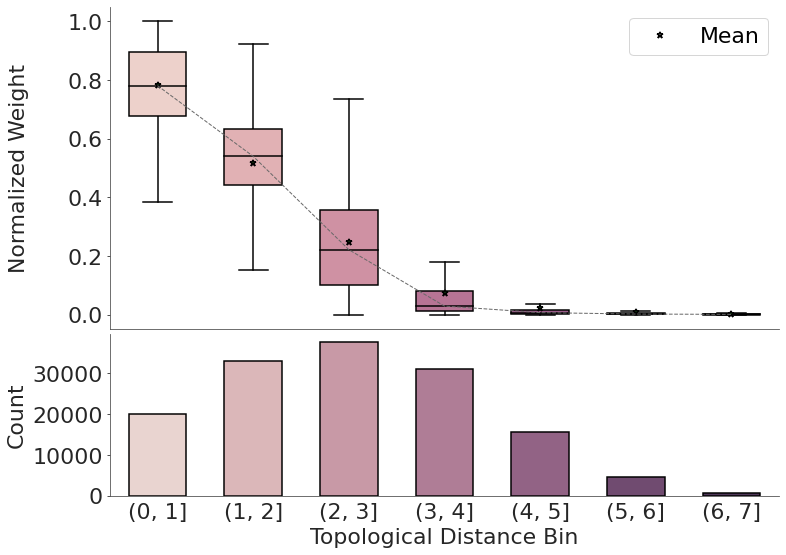

In [8]:
data = pd.DataFrame({'top_distance': rpDs, 'bond_weights': bws})
data['binned'] = pd.cut(x=data['top_distance'], bins=range(8))
make_violinplot(x=data['binned'], y=data['bond_weights'], data=data, counts=True, box_only=True,
                showfliers=False, xlabel='Topological Distance Bin', ylabel='Normalized Weight', 
                counts_label='Count', connect_medians=True,
                figsize=(12,9), path=None)

In [10]:
from __future__ import unicode_literals

def generate_importance_plot(i, save=False):

    # topological distance matrix
    rD = (Chem.GetDistanceMatrix(r_mols[i]) == 1)*1
    pD = (Chem.GetDistanceMatrix(p_mols[i]) == 1)*1
    rpD = (rD+pD)/2
    #rpDs.append(rpD)

    # 3D distance matrix
    r3D = Chem.Get3DDistanceMatrix(r_mols[i])
    p3D = Chem.Get3DDistanceMatrix(p_mols[i])
    rp3D = (r3D+p3D)/2
    #rp3Ds.append(rp3D)

    mol = ts_mols[i]
    n_atoms = mol.GetNumAtoms()
    w = raw_weights[i][raw_weights[i] != 0].reshape(n_atoms,n_atoms)
    bond_weights = w / np.max(w) #np.divide(w,max(np.max(w, axis=1)))  # normalize
    #bond_weight_matrices.append(bond_weights)
    
    # generate labels for plot
    labels = 2*(pD - rD) + (rD*pD)
    labels = np.array(labels, dtype=str)
    labels = np.where(labels=='2', '+', labels) 
    labels = np.where(labels=='-2', '-', labels)
    labels = np.where(labels=='0', '', labels) 
    # labels = np.where(labels=='1', '*', labels) 
    labels = np.where(labels=='1', u'\u2022', labels) 
    
    # draw reactant and product
    r_mol = r_mols[i]
    r_drawing = draw(r_mol, atomLabels=True)
    display(SVG(r_drawing))
    p_mol = p_mols[i]
    p_drawing = draw(p_mol, atomLabels=True)
    display(SVG(p_drawing))
    
    # plot importance
    grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
    cbar_kws={"orientation": "horizontal"}
    fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(12,12))
    mask = np.zeros_like(bond_weights, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True
    ax = sns.heatmap(bond_weights**2, ax=ax, cbar_ax=cbar_ax, mask=mask, cbar_kws=cbar_kws,
                     cmap=sns.cubehelix_palette(light=0.9, as_cmap=True), annot=labels, fmt="", annot_kws={"size": 20})
    ax.set_xlabel('Atom Index', fontsize=14)
    ax.set_ylabel('Atom Index', fontsize=14)
    ax.set_title('Perceived Important Distances', fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
    cbar_ax.set_title('Weight', fontsize=14, loc='right')
    
    if save:
        ax.figure.savefig('/home/lagnajit/Desktop/12_4_gm_images/plot' + str(1) + '.png', dpi=2000, bbox_inches='tight')

In [ ]:
generate_importance_plot(2, save=False)